# Ensembles

In these notes, we will investigate the use of **ensemble** methods for supervised learning.

- [Ensembles | `sklearn` User Guide](https://scikit-learn.org/stable/modules/ensemble.html)

In [1]:
# general imports
import numpy as np
import pandas as pd
from joblib import parallel_backend

# data generation and loading
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import plot_tree
from sklearn.tree import export_text

# basic classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# basic regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# ensembles for classification
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# ensembles for regression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# model tuning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# model metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
# helper function to plot decision boundaries
def plot_decision_boundary(model, X, y, model_name):
    cmap = matplotlib.colors.ListedColormap(
        ["tab:blue", "tab:orange", "tab:gray"],
    )
    _, ax = plt.subplots(figsize=(8, 6))
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
        grid_resolution=200,
        alpha=0.4,
        xlabel="$x_1$",
        ylabel="$x_2$",
        ax=ax,
        cmap=cmap,
    )
    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        edgecolor="w",
        cmap=cmap,
    )
    ax.set_title(f"{model_name}: Decision Boundary")
    plt.show()

In [3]:
# helper function to simulate some example data
def generate_example_data(n=10, seed=None):
    np.random.seed(seed)
    data = {
        "Age": np.random.randint(
            18,
            70,
            size=n,
        ),
        "Income": np.random.randint(
            50000,
            150000,
            size=n,
        ),
        "Education": np.random.choice(
            ["High School", "Bachelor", "Master", "PhD"],
            size=n,
        ),
    }
    df = pd.DataFrame(data)
    return df

In [4]:
# function to simulate data (in numpy) for regression task
def simulate_sin_data(n=25, seed=42):
    np.random.seed(seed)
    X = np.random.uniform(low=-2 * np.pi, high=2 * np.pi, size=(n, 1))
    e = np.random.normal(loc=0, scale=0.25, size=(n, 1))
    y = np.sin(X) + e
    y = y.ravel()
    return X, y


# helper function for plotting sin data and learned regression model
def plot_sin_regression(model, X_train, y_train, title, ax=None):
    x_plot = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
    x_plot = x_plot.reshape((1000, 1))
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(
        X_train,
        y_train,
        label="Actual",
        zorder=2,
        c="tab:blue",
    )
    ax.plot(
        x_plot,
        model.predict(x_plot),
        color="tab:orange",
        linewidth=2,
        label="Fitted",
    )
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_ylim(-3, 3)
    ax.grid(
        color="lightgrey",
        linestyle="--",
        zorder=0,
    )
    ax.legend()
    ax.set_title(title)

In [5]:
# helper function to better display results of cross-validation
def cv_results_to_df(cv_results):
    params = pd.DataFrame(cv_results["params"])
    params.columns = [col.split("__")[-1] for col in params.columns]
    scores = pd.DataFrame(
        {
            "mean_test_score": cv_results["mean_test_score"],
            "std_test_score": cv_results["std_test_score"],
        }
    )
    results_df = pd.concat([params, scores], axis=1)
    results_df["mean_test_score"] = results_df["mean_test_score"].map("{:.2f}".format)
    results_df["std_test_score"] = results_df["std_test_score"].map("{:.2f}".format)
    return results_df

## Some Review

Let $X_1, X_2, \dots, X_n \sim F$, where each $X_i$ has:

- population mean $\mu = \mathbb{E}[X_i]$,
- population variance $\sigma^2 = \text{Var}(X_i)$.

Recall that the sample mean is defined as:

$$
\bar{X} = \frac{1}{n} \sum_{i=1}^{n} X_i
$$

The expected value (mean) of the sample mean is:

$$
\mathbb{E}[\bar{X}] = \mu.
$$

If we can additionally assume that the $X_i$ are independent, the **variance** of the sample mean is:

$$
\text{Var}(\bar{X}) = \frac{\sigma^2}{n}.
$$

Importantly: *The variance of an average is smaller (proportional to the sample size) than the variance of an individual observation.*

However, if we cannot make the independence assumption, the variance has an additional term:

$$
\text{Var}(\bar{X}) = \frac{\sigma^2}{n} + \text{(an additional term that depends on the covariances)}.
$$

For our purposes, the specifics of this terms is not important, only that it exists, and the stronger the covariance, the larger the term. To the extent that we have control, we will seek to reduce the covariances to keep variances low.

## Key Ideas

**Ensembles** are conceptually very simple. An ensemble is simply a model that is a combination of other models. Often, ensembles are created through the following general process:

- Fit "many" models to train data.
    - These models are called the **base learners**.
    - "Many" can be as few as two or as many as a computer's memory will allow.
- Make predictions with each model that was fit.
    - "Average" these predictions to make a prediction from the ensemble.
        - For regression: literally average the predictions.
        - For classification: different "voting" mechanisms available.

We will consider "custom" ensembles using `VotingRegressor()` and `VotingClassifier()`, but more importantly we will look at two general forms of ensembles:

- Bagging ("Bootstrap Aggregation")
- Boosting

*How* and *why* do these methods work?

- **Bagging** uses many *strong* base learners in *parallel* and attempts to _reduce the **variance**_ of the base learners through averaging.
    - A *strong learner* is very effective at learning the training data and thus is likely to *overfit*.
- **Boosting** uses many *weak* base learners in *sequence* and attempts to _reduce the **bias**_ of the base learners.
    - A *weak learner* is potentially unable to learn the training data well and thus is likely to *underfit*.

For bagging, we will focus on a particular variant called a **random forest**, which as the name suggests, uses a collection of decision trees.

For boosting, we will focus on a modern algorithm called **histogram gradient boosting** which is inspired by the popular and effective [LightGBM](https://lightgbm.readthedocs.io/en/latest/).

Each of these methods can be used for both regression and classification.

## Custom (Voting) Regression Ensemble

Using `VotingRegressor()`, we can easily create a custom ensemble for regression.

- [`sklearn.ensemble.VotingRegressor` | API Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html)

In [6]:
# simulate some data for regression
X, y = make_regression(
    n_samples=300,
    n_features=5,
    noise=0.3,
    random_state=42,
)

# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
)

In [7]:
# create three (different) base learners
linear = LinearRegression()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()

In [8]:
# fit the base learners
_ = linear.fit(X_train, y_train)
_ = knn.fit(X_train, y_train)
_ = tree.fit(X_train, y_train)

In [9]:
# make predictions on (some) of the test observations
predictions = (
    linear.predict(X_test[:3]),
    tree.predict(X_test[:3]),
    knn.predict(X_test[:3]),
)
predictions

(array([-32.15932366, -22.28278917,   2.22604893]),
 array([-10.61666369, -26.73985752,  57.21089151]),
 array([-18.96972927, -15.03687023,   7.67073112]))

In [10]:
# create a custom ensemble using the base learners
ensemble = VotingRegressor(
    [
        ("linear", linear),
        ("knn", knn),
        ("tree", tree),
    ]
)
ensemble

VotingRegressor(estimators=[('linear', LinearRegression()),
                            ('knn', KNeighborsRegressor()),
                            ('tree', DecisionTreeRegressor())])

In [11]:
# fit the custom ensemble
_ = ensemble.fit(X_train, y_train)

In [12]:
# make predictions on (some) of the test observations
ensemble.predict(X_test[:3])

array([-26.22366501, -14.41966595,  19.2119982 ])

In [13]:
# average the predictions from the base learners
np.mean(predictions, axis=0)

array([-20.58190554, -21.35317231,  22.36922385])

Notice that we have verified that the predictions from the ensemble are indeed the average of the predictions from the base learners.

## Custom (Voting) Classification Ensemble

Using `VotingClassifier()`, we can easily create custom ensembles for classification.

- [`sklearn.ensemble.VotingClassifier` | API Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [14]:
# simulate some data for classification
X, y = make_blobs(
    n_samples=400,
    cluster_std=3,
    random_state=42,
)

# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.50,
    random_state=42,
)

In [15]:
# create three (different) base learners
logistic = LogisticRegression()
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()

In [16]:
# fit the base learners
_ = logistic.fit(X_train, y_train)
_ = knn.fit(X_train, y_train)
_ = tree.fit(X_train, y_train)

Before investigating the voting classifier, let's first look at the decision boundaries created by the three base learners.

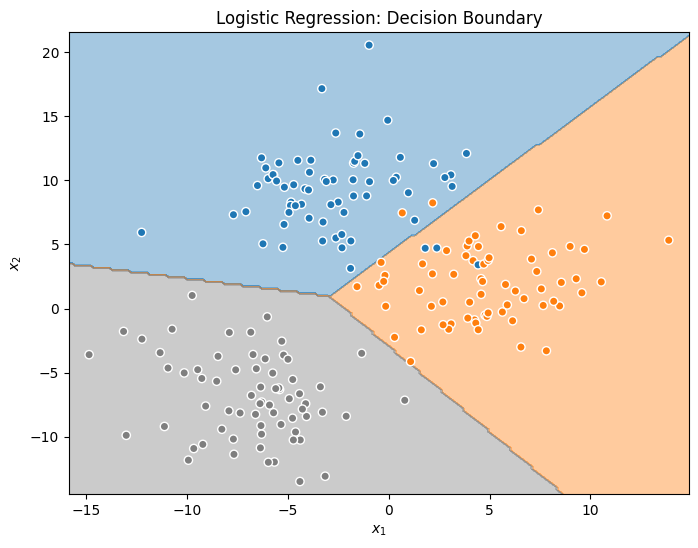

In [17]:
plot_decision_boundary(logistic, X_test, y_test, "Logistic Regression")

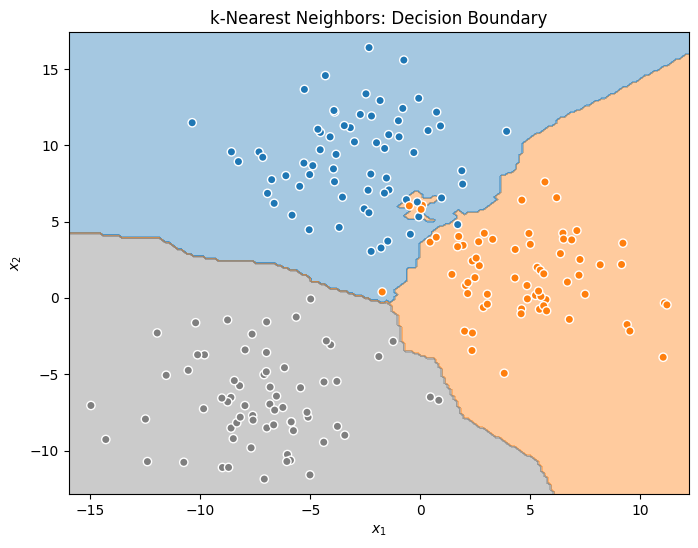

In [18]:
plot_decision_boundary(knn, X_train, y_train, "k-Nearest Neighbors")

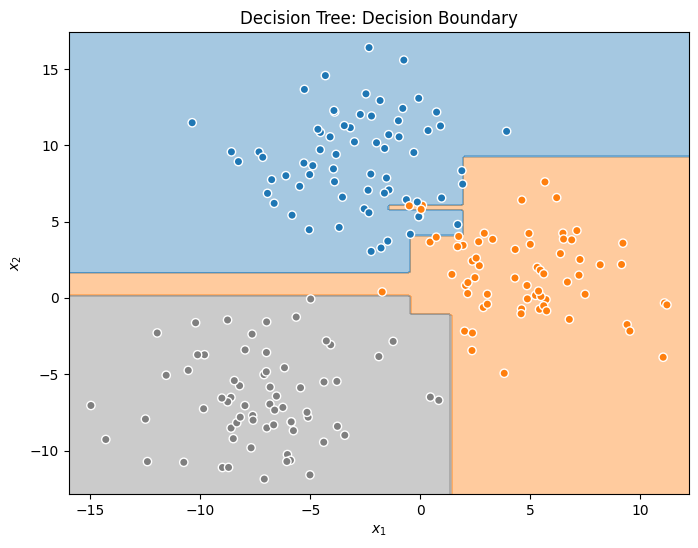

In [19]:
plot_decision_boundary(tree, X_train, y_train, "Decision Tree")

In [20]:
# create a custom soft voting ensemble using the base learners
ensemble_soft = VotingClassifier(
    [
        ("logistic", logistic),
        ("knn", knn),
        ("tree", tree),
    ],
    voting="soft",
)
ensemble_soft

VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('knn', KNeighborsClassifier()),
                             ('tree', DecisionTreeClassifier())],
                 voting='soft')

In [21]:
# fit the custom ensemble
_ = ensemble_soft.fit(X_train, y_train)

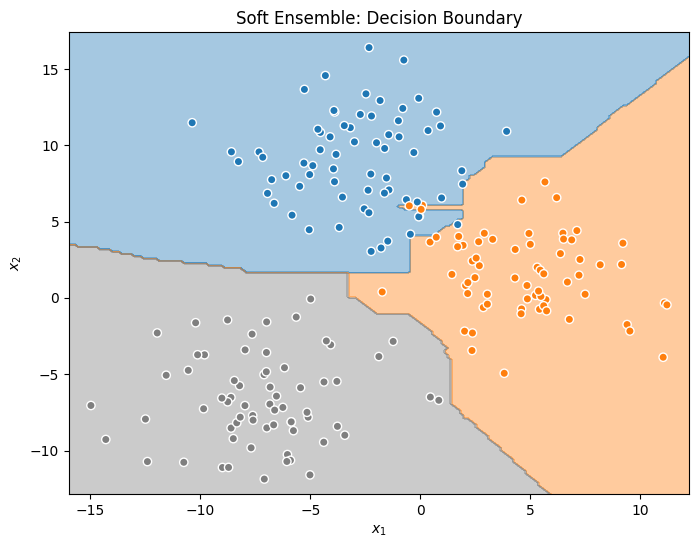

In [22]:
plot_decision_boundary(ensemble_soft, X_train, y_train, "Soft Ensemble")

Notice that the decision boundary for the soft voting classifier is quite different than each of the base learners, but in some sense contains patterns from each of the base learners.

In [23]:
# create a custom hard voting ensemble using the base learners
ensemble_hard = VotingClassifier(
    [
        ("logistic", logistic),
        ("knn", knn),
        ("tree", tree),
    ],
    voting="hard",
)
ensemble_hard

VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('knn', KNeighborsClassifier()),
                             ('tree', DecisionTreeClassifier())])

In [24]:
# fit the custom ensemble
_ = ensemble_hard.fit(X_train, y_train)

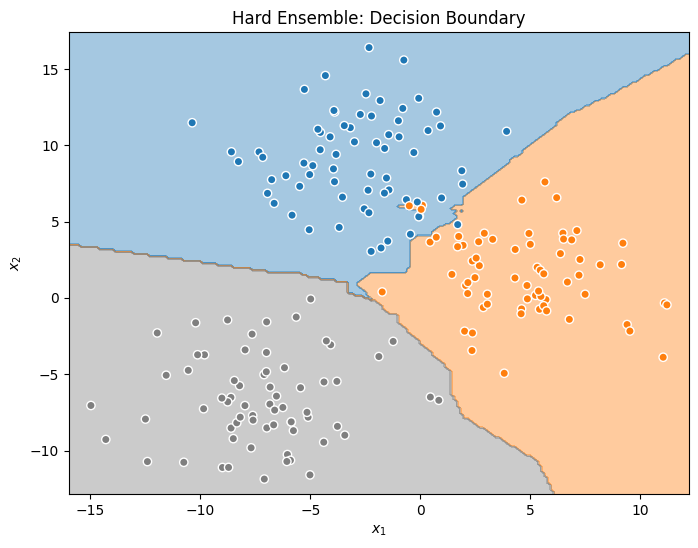

In [25]:
plot_decision_boundary(ensemble_hard, X_train, y_train, "Hard Ensemble")

What is the difference between **soft voting** and **hard voting**?

- Hard Voting: Predict the class with the most votes from the base models.
- Soft Voting. Predict the class with the largest average probability from the base learners.

For example consider five learners for a classification task. The target value has possible values `A`, `B`, and `C`. For each learner, we have a prediction and estimated probabilities (of `[A, B, C]`) for a single observation.

- Learner 1
    - Prediction: `A`
    - Probabilities; `[0.6, 0.0, 0.4]`
- Learner 2
    - Prediction: `B`
    - Probabilities: `[0.3, 0.4, 0.3]`
- Learner 3
    - Prediction: `C`
    - Probabilities: `[0.1, 0.0, 0.9]`
- Learner 2
    - Prediction: `B`
    - Probabilities: `[0.2, 0.5, 0.3]`
- Learner 2
    - Prediction: `B`
    - Probabilities: `[0.2, 0.5, 0.3]`

Using hard voting, we see there are three learners predicting `B`, thus this is the majority vote, and the prediction made via hard voting.

With soft voting, we must first average the probabilities, which gives: `[0.28, 0.28, 0.44]`. Thus, because the `C` class has the highest probability, the prediction made with soft voting is `C`.

In [26]:
# make predictions on (some) of the test observations
some_test_predictions = X_test[20:30]
predictions = (
    logistic.predict(some_test_predictions),
    knn.predict(some_test_predictions),
    tree.predict(some_test_predictions),
)
predictions

(array([1, 1, 2, 1, 2, 1, 2, 0, 1, 2]),
 array([1, 1, 2, 1, 2, 1, 2, 0, 1, 2]),
 array([1, 1, 2, 1, 2, 2, 2, 0, 1, 2]))

In [27]:
# make predictions on (some) of the test observations
ensemble_hard.predict(some_test_predictions)

array([1, 1, 2, 1, 2, 1, 2, 0, 1, 2])

In [28]:
# make predictions on (some) of the test observations
ensemble_soft.predict(some_test_predictions)

array([1, 1, 2, 1, 2, 2, 2, 0, 1, 2])

While most of the predictions are the same, notice that the hard and soft voting classifiers make slightly different predictions, in this case, on one particular observation. You can see this effect more generally by comparing the plots of the decision boundaries above.

In [29]:
# get probabilities for a test observation
single_test_obs = X_test[[20]]
probabilities = (
    logistic.predict_proba(single_test_obs),
    knn.predict_proba(single_test_obs),
    tree.predict_proba(single_test_obs),
)
probabilities

(array([[0.14546585, 0.8438736 , 0.01066055]]),
 array([[0.4, 0.6, 0. ]]),
 array([[0., 1., 0.]]))

Note that it is not possible to obtain probabilities with a hard voting ensemble in `sklearn`. Attempting to do so would produce the following error:

- `AttributeError: predict_proba is not available when voting='hard'`

In [30]:
# get probabilities for a test observation
ensemble_soft.predict_proba(single_test_obs)

array([[0.18182195, 0.81462453, 0.00355352]])

In [31]:
# average probabilities from the base learners
np.mean(probabilities, axis=0)

array([[0.18182195, 0.81462453, 0.00355352]])

Notice that the average of the probabilities from the base learners is the same as the probabilities obtained from the soft voting classifier.

## The Bootstrap

Before introducing random forests, we take a quick detour to describe the bootstrap.

[**Bootstrapping**](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a powerful and important technique in statistics developed by Bradley Efron in the late 1970s and early 1980s.

![A sample is drawn from a population. From this sample, resamples are generated by sampling with replacement. Data points that were drawn more than once (which happens for approx. 26.4% of data points) are shown in red and slightly offset. From the resamples, a statistic is calculated and, therefore, a histogram can be calculated to estimate the distribution of that statistic. Original Source: [Wikipedia](https://commons.wikimedia.org/wiki/File:Illustration_bootstrap.svg).](img/bootstrap.svg)

While the bootstrap has many uses, we will narrowly focus on the *resampling* aspect of the method. That is, generating datasets that are similar (appear to have been sampled from the same distribution as the original dataset) but contain different observations.

In [32]:
example_sample = generate_example_data(seed=42)
example_sample

,Age,Income,Education
0,56,87194,PhD
1,69,137498,Bachelor
2,46,94131,Bachelor
3,32,110263,Bachelor
4,60,66023,PhD
5,25,91090,PhD
6,38,117221,High School
7,56,114820,High School
8,36,50769,PhD
9,40,109735,Bachelor


A *bootstrap resample* is a dataset that has the same dimension as the original data, importantly the same number of observations. These observations are sampled **with replacement**.

In [33]:
# function to produce a bootstrap resample
def generate_bootstrap_resample(df, seed=None):
    resample = df.sample(
        n=len(df),
        replace=True,
        random_state=seed,
    )
    return resample

We'll generate three new bootstrap resamples based on the `example_sample` data. Importantly, you should notice two things about each bootstrap resample:

- Sometimes, an original observation is duplicated,
- Sometimes, an original observation is not included.

Pay attention to the printed index which will make these easy to see.

In [34]:
generate_bootstrap_resample(example_sample, seed=1)

,Age,Income,Education
5,25,91090,PhD
8,36,50769,PhD
9,40,109735,Bachelor
5,25,91090,PhD
0,56,87194,PhD
0,56,87194,PhD
1,69,137498,Bachelor
7,56,114820,High School
6,38,117221,High School
9,40,109735,Bachelor


In [35]:
generate_bootstrap_resample(example_sample, seed=2)

,Age,Income,Education
8,36,50769,PhD
8,36,50769,PhD
6,38,117221,High School
2,46,94131,Bachelor
8,36,50769,PhD
7,56,114820,High School
2,46,94131,Bachelor
1,69,137498,Bachelor
5,25,91090,PhD
4,60,66023,PhD


In [36]:
generate_bootstrap_resample(example_sample, seed=3)

,Age,Income,Education
8,36,50769,PhD
9,40,109735,Bachelor
3,32,110263,Bachelor
8,36,50769,PhD
8,36,50769,PhD
0,56,87194,PhD
5,25,91090,PhD
3,32,110263,Bachelor
9,40,109735,Bachelor
9,40,109735,Bachelor


The "trick" employed by the bootstrap is that each bootstrap resample could be considered a "new" random sample from the population. Of course this is not actually the case, and thus there are limitations to the bootstrap, however it often works well when the original random sample is quite large. We'll skip these details for now. We are simply interested in being able to generate these bootstrap resamples.

## Random Forest

As you might imagine from the name, a random _**forest**_ is a collection of **trees**. The "random" in random forests is usually introduced through two distinct sources.

Suppose we fit 100 decision trees, each to the same training data. This would be an odd thing to do, because each of these trees will make the same predictions! Averaging them would be no different than using a single tree. The predictions from these trees would be perfectly correlated! And thus, we'd see exactly zero reduction in variance from using this procedure.

How can we de-correlate (reduce covariance) between the base learners? *Add randomness to decrease correlation between the base learners.* This might seem quite odd because in some sense, we are adding variability to each individual tree. But it turns out that doing so will reduce the variance of an ensemble that leverages these base learners with added randomness.

With sufficiently de-correlated trees, averaging the predictions from the trees significantly **reduces variance** compared to a single tree.

How do we add this randomness to individual trees?

- Use "different" data when fitting each tree.
- Add randomness when determining the splits for each tree.

To address the first, we will use *bootstrap resamples*. Fitting trees to bootstrap resamples will "de-correlate" the trees in that they will not always produce the same predictions.

To address the second, we will modify the usual tree fitting procedure. Recall the parameters available when fitting a decision tree.

In [37]:
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

You may have wondered: Why is there a `random_state` parameter? What randomness would we ever need to control for reproducibility?

The `max_features` parameter is the answer to this question. By default, with a value of `None`, decision trees consider all feature variables when determining the best split of each node during the fitting process. However, this parameter allows us to alter this part of the process. We can limit the number of features considered for each split, *at random*. That is, if we set `max_features=1`, the most extreme case, when determining a split, rather than consider all available features, we first randomly select a feature, then find the best possible split of the available splits with *only that feature*. 

Note that, this randomly selected feature is *not* used for *all* splits. Instead, each time the method attempts a split, it randomly chooses a feature.

This parameter can be set to be any value between 1 and the number of features available. Using 1 adds the most variability to the fitting procedure, and thus de-correlates the trees as much as possible. Using all features does not add any variability, and thus provides no additional de-correlation. (De-correlation would still be introduced via the bootstrap resampling.) Eventually, we will consider this parameter a tuning parameter of random forests. Setting another integer value for this parameter, say 2, would consider splits of 2 randomly chosen features.

As seen in the documentation, there are two built-in options for `max_features` that can be expressed as strings: 

- If `"sqrt"`, then `max_features=sqrt(n_features)`.
- If `"log2"`, then `max_features=log2(n_features)`.

These two options are well supported in the literature, and we will see that `"sqrt"` is recommended for random forests. While we *can* tune this parameter, it is generally not worthwhile. It often provides little benefit, but incurs a large computational cost.

The trees fit and then combined to produce a random forest are generally *strong learners*. Specifically for decision trees, that generally means that each individual tree will likely be overfit, specifically by growing a very deep tree. Trees in random forests are often unconstrained in any way, splitting until each node is pure. Within `sklearn`, random forests can be controlled via any of the usual parameters that control trees, but by default, the individual trees in a forest will be allowed to grow large.

The number of trees in the forest is also a potential tuning parameter. For a random forest to work well, it simply needs "enough" trees. By default, `sklearn` will use 100, which is almost always sufficient. Another commonly suggested value is 500.

In **summary**, the key elements of a random forest are:

- A "large" collection, that is an **ensemble**, of **decision trees**.
- Each tree in the ensemble is fit to a **bootstrap resample**.
- Trees in the collection are generally **strong learners**, thus (over)fit the training data very well.
- When determining a split, only a **random sample of features** are considered.
- Predictions are made by **averaging** the predictions of the individual trees which provides significant **variance reduction**, and thus potential performance improvements.

In [38]:
# function to fit a "random" tree like those in a random forest
def fit_random_tree(df, seed=None):
    br = generate_bootstrap_resample(df, seed=seed)
    y_br = br["Income"]
    X_br = br[["Age", "Education"]]
    X_br = pd.get_dummies(X_br)
    dt = DecisionTreeRegressor(max_depth=1, max_features=1)
    _ = dt.fit(X_br, y_br)
    return dt

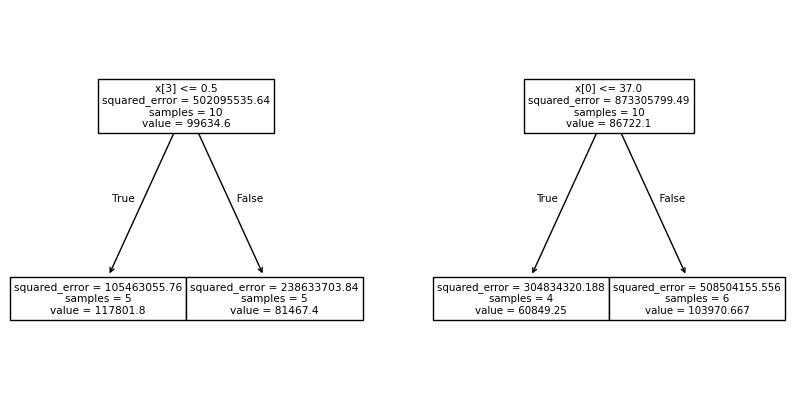

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

_ = plot_tree(fit_random_tree(example_sample, seed=1), ax=axes[0])
_ = plot_tree(fit_random_tree(example_sample, seed=2), ax=axes[1])

plt.show()

Here we see two trees, both fit to a bootstrap resample of some original data, using one split of a randomly chosen feature. Notice that these tress will *not* make the same predictions.

In [40]:
print(export_text(fit_random_tree(example_sample, seed=1)))

|--- feature_0 <= 37.00
|   |--- value: [77649.67]
|--- feature_0 >  37.00
|   |--- value: [109056.71]



In [41]:
print(export_text(fit_random_tree(example_sample, seed=2)))

|--- feature_2 <= 0.50
|   |--- value: [79397.50]
|--- feature_2 >  0.50
|   |--- value: [116020.50]



### Random Forests for Regression

In `sklearn`, random forests can be used for regression with `RandomForestRegressor()`.

- [`sklearn.ensemble.RandomForestRegressor` | `sklearn` API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

#### Simulated Sinusoidal Data

To investigate random forests for regression, we will return to the familiar simulated sinusoidal data.

In [42]:
# simulate train data
X_train, y_train = simulate_sin_data(n=200, seed=1)

# simulate test data
X_test, y_test = simulate_sin_data(n=200, seed=2)

In [43]:
tree_default = DecisionTreeRegressor()
_ = tree_default.fit(X_train, y_train)

tree_modified = DecisionTreeRegressor(max_depth=5)
_ = tree_modified.fit(X_train, y_train)

rf_default = RandomForestRegressor()
_ = rf_default.fit(X_train, y_train)

rf_modified = RandomForestRegressor(max_samples=25)
_ = rf_modified.fit(X_train, y_train)

We create and fit four models:

- A decision tree with all default parameters.
- A decision tree with some modified parameters.
- A random forest with all default parameters.
- A random forest with some modified parameters.

In this case, we modify the `max_samples` parameter to the random forest. This parameter is used to control the number of observations in the bootstrap resample. While generally not considered one of the key tuning parameters of a random forest, it can often provide a useful performance benefits. In some sense, decreasing the value of provides an implicit form of regularization.

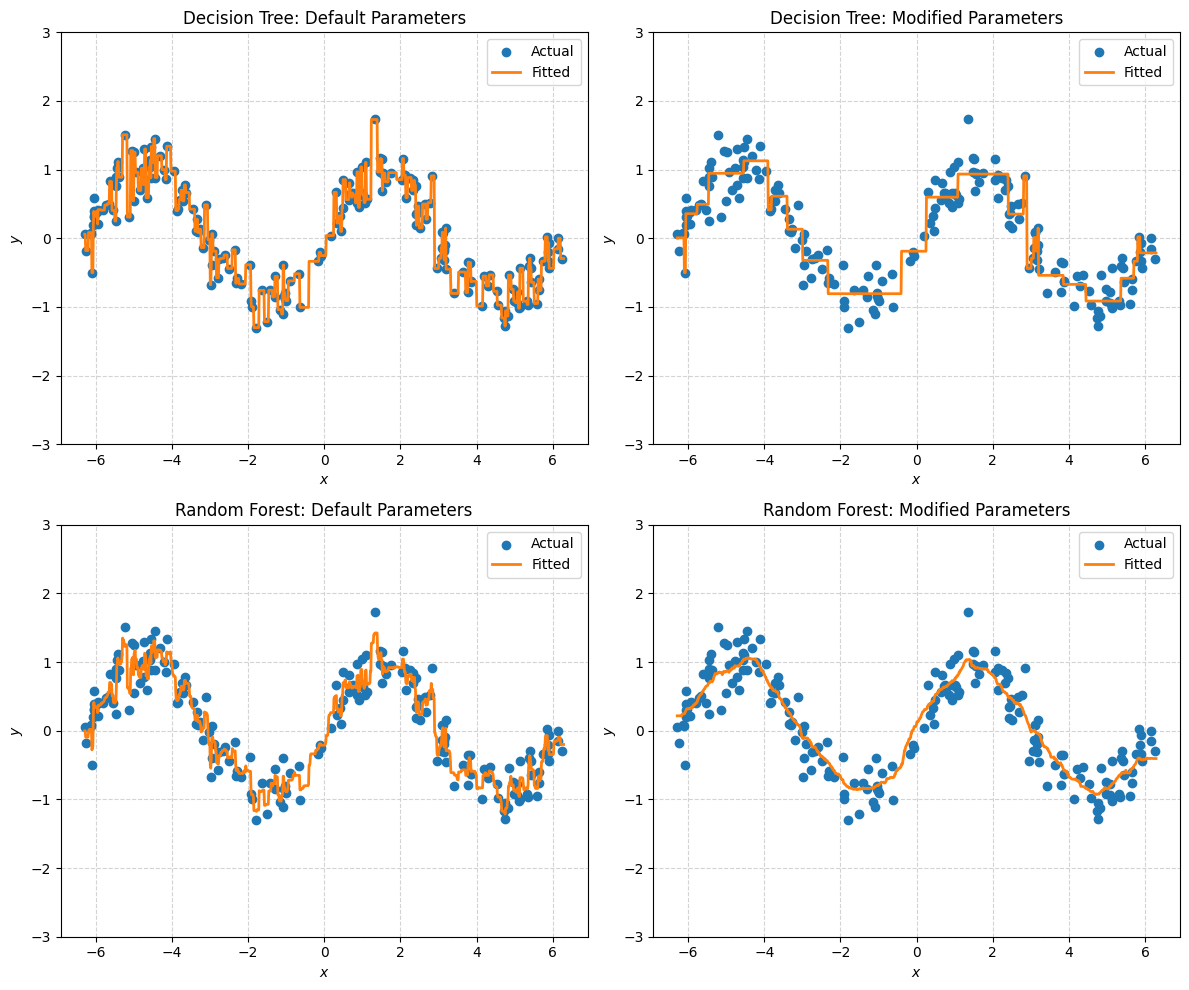

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_sin_regression(
    tree_default,
    X_train,
    y_train,
    "Decision Tree: Default Parameters",
    ax=axs[0, 0],
)
plot_sin_regression(
    tree_modified,
    X_train,
    y_train,
    "Decision Tree: Modified Parameters",
    ax=axs[0, 1],
)
plot_sin_regression(
    rf_default,
    X_train,
    y_train,
    "Random Forest: Default Parameters",
    ax=axs[1, 0],
)
plot_sin_regression(
    rf_modified,
    X_train,
    y_train,
    "Random Forest: Modified Parameters",
    ax=axs[1, 1],
)

plt.tight_layout()
plt.show()

Notice:

- The default tree is obviously overfit. It is an example of a strong learner. It is making far too many splits.
- The modified tree is not overfit, but just by visual inspection, the predictions are too "discrete" in some sense, that is, not smooth enough.
- The default forest already shows improvement over default tree. It avoids the overfitting of the default tree. Visually, this forest looks a bit better than the modified tree, but may not provide much performance improvement.
- The modified forest looks great! Decreasing the samples used when bootstrapping had a "smoothing" effect on the learned regression.

In [45]:
rsme_tree_default = root_mean_squared_error(
    y_test,
    tree_default.predict(X_test),
)

rsme_tree_modified = root_mean_squared_error(
    y_test,
    tree_modified.predict(X_test),
)

rsme_rf_default = root_mean_squared_error(
    y_test,
    rf_default.predict(X_test),
)

rsme_rf_modified = root_mean_squared_error(
    y_test,
    rf_modified.predict(X_test),
)

In [46]:
print(f"Test RMSE for default Tree: {rsme_tree_default:.2f}")
print(f"Test RMSE for modified Tree: {rsme_tree_modified:.2f}")
print(f"Test RMSE for default Random Forest: {rsme_rf_default:.2f}")
print(f"Test RMSE for modified Random Forest: {rsme_rf_modified:.2f}")

Test RMSE for default Tree: 0.39
Test RMSE for modified Tree: 0.33
Test RMSE for default Random Forest: 0.33
Test RMSE for modified Random Forest: 0.29


We see that the test RMSE of each model confirms our visual intuition above.

#### Simulated Multiple Feature Data

To further investigate random forests, we'll simulate data using the `make_regression` from `sklearn`. The sinusoidal data only contained a single feature, so could not fully showcase the potential of random forests, as they could not use random features during splitting.

In [47]:
# simulate some data for regression
X, y = make_regression(
    n_samples=300,
    n_features=5,
    noise=0.3,
    random_state=42,
)

# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
)

In [48]:
dt2 = DecisionTreeRegressor(max_depth=2)
dt5 = DecisionTreeRegressor(max_depth=5)
rf = RandomForestRegressor()

In [49]:
_ = dt2.fit(X_train, y_train)
_ = dt5.fit(X_train, y_train)
_ = rf.fit(X_train, y_train)

In [50]:
dt2_pred = dt2.predict(X_test)
dt5_pred = dt5.predict(X_test)
rf_pred = rf.predict(X_test)

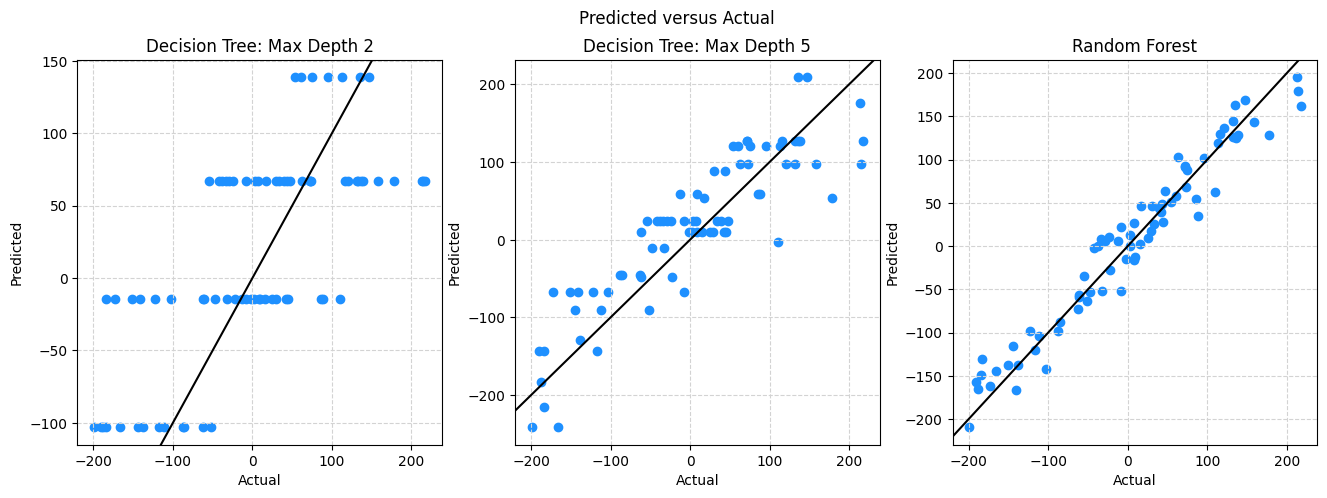

In [51]:
# setup figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 5)
fig.set_dpi(100)

# add overall title
fig.suptitle("Predicted versus Actual")

# create subplot for dt
ax1.set_title("Decision Tree: Max Depth 2")
ax1.scatter(y_test, dt2_pred, color="dodgerblue")
ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.grid(True, linestyle="--", color="lightgrey")
ax1.axline((0, 0), slope=1, color="black")

# create subplot for dt
ax2.set_title("Decision Tree: Max Depth 5")
ax2.scatter(y_test, dt5_pred, color="dodgerblue")
ax2.set_xlabel("Actual")
ax2.set_ylabel("Predicted")
ax2.grid(True, linestyle="--", color="lightgrey")
ax2.axline((0, 0), slope=1, color="black")

# create subplot for rf
ax3.set_title("Random Forest")
ax3.scatter(y_test, rf_pred, color="dodgerblue")
ax3.set_xlabel("Actual")
ax3.set_ylabel("Predicted")
ax3.grid(True, linestyle="--", color="lightgrey")
ax3.axline((0, 0), slope=1, color="black")

# shot plot
plt.show()

Simply looking at the predicted versus actual plots, we can clearly see the random forest outperforming the single trees. (Calculate test RMSE for each to verify!) Also note that with limited depth, trees will only predict a finite number of unique values. Because of the averaging and randomness of random forests, predictions are much less discrete.

### Random Forests for Classification

In `sklearn`, random forests can be used for classification with `RandomForestClassifier()`.

- [`sklearn.ensemble.RandomForestClassifier` | `sklearn` API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [52]:
# simulate some data for classification
X, y = make_blobs(
    n_samples=400,
    cluster_std=3,
    random_state=42,
)

# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.50,
    random_state=42,
)

In [53]:
# create and fit a single decision tree
tree = DecisionTreeClassifier()
_ = tree.fit(X_train, y_train)

# create and fit a random forest
rf = RandomForestClassifier()
_ = rf.fit(X_train, y_train)

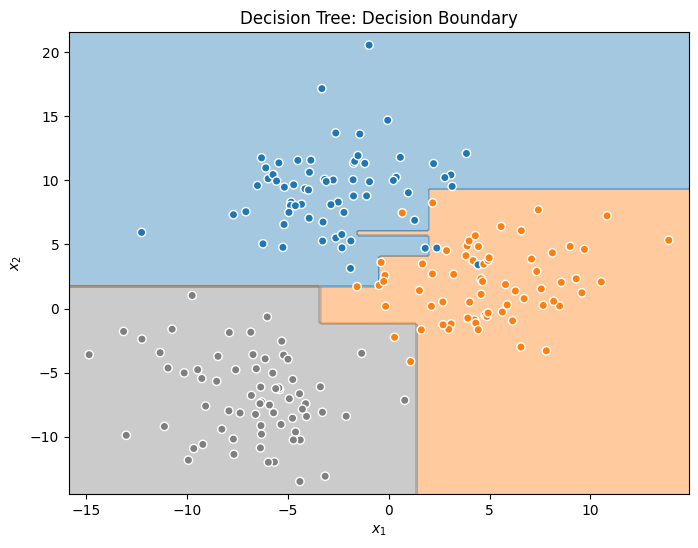

In [54]:
plot_decision_boundary(tree, X_test, y_test, "Decision Tree")

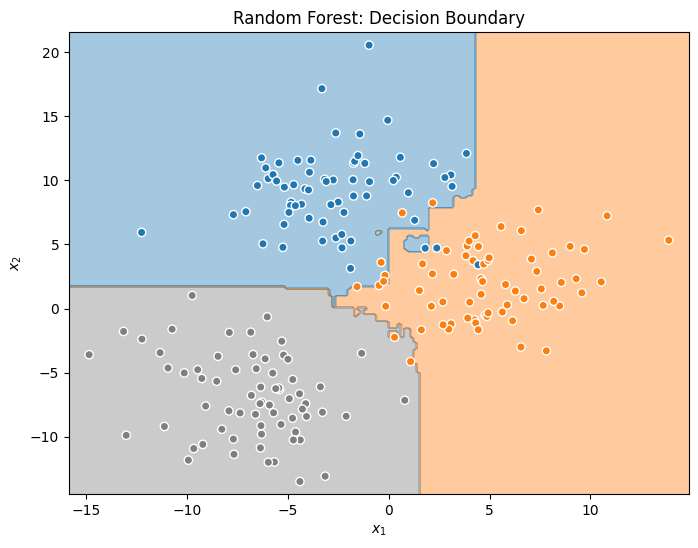

In [55]:
plot_decision_boundary(rf, X_test, y_test, "Random Forest")

In [56]:
# calculate test accuracies
acc_tree = accuracy_score(y_test, tree.predict(X_test))
acc_rf = accuracy_score(y_test, rf.predict(X_test))

In [57]:
print(f"Test Accuracy for Decision Tree: {acc_tree:.2f}")
print(f"Test Accuracy for Random Forest: {acc_rf:.2f}")

Test Accuracy for Decision Tree: 0.97
Test Accuracy for Random Forest: 0.95


Note that in this (simple) case, the tree actually outperforms the forest! This is certainly possible in practice, but notice that the difference is small, and with more meaningful and complicated data, a random forest will usually outperform a tree. But this should be a reminder that you have to try many models and see what works best! You might also notice that the decision boundaries for the random forest seem more "correct" in the sense that we would doubt that the boundaries can be well represented by simple binary partitions.

In [58]:
tree.predict_proba(X_test[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [59]:
rf.predict_proba(X_test[:10])

array([[0.01, 0.95, 0.04],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.95, 0.05, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.24, 0.76, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.96, 0.04]])

As always, we can obtain predicted probabilities with a random forest. Note that unlike the tree, these probabilities seem more reasonable and do not simply place a probability of `1` on a class for each observation.

Random forests use the soft voting mechanism to determine probabilities, and thus predictions.

### Tuning

To demonstrate tuning with random forests, we will use the diabetes data from `sklearn`.

- [Diabetes | `sklearn` Datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset)

In [60]:
# load diabetes data from sklearn
diabetes = load_diabetes(as_frame=True, scaled=False).frame

# train-test split the data
diabetes_train, diabetes_test = train_test_split(
    diabetes,
    test_size=0.2,
    random_state=42,
)

# create the X and y version of the train data
X_train = diabetes_train.drop("target", axis=1)
y_train = diabetes_train["target"]

# create the X and y version of the test data
X_test = diabetes_test.drop("target", axis=1)
y_test = diabetes_test["target"]

# check shapes of data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((353, 10), (353,), (89, 10), (89,))

In [61]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
17,68.0,2.0,27.5,111.0,214.0,147.0,39.0,5.0,4.9416,91.0
66,46.0,2.0,24.7,85.0,174.0,123.2,30.0,6.0,4.6444,96.0
137,50.0,1.0,31.0,123.0,178.0,105.0,48.0,4.0,4.8283,88.0
245,41.0,1.0,23.1,86.0,148.0,78.0,58.0,3.0,4.0943,60.0
31,42.0,1.0,20.3,71.0,161.0,81.2,66.0,2.0,4.2341,81.0


In [62]:
y_train

17     144.0
66     150.0
137    280.0
245    125.0
31      59.0
       ...  
106    134.0
270    202.0
348    148.0
435     64.0
102    302.0
Name: target, Length: 353, dtype: float64

In [63]:
# create pipeline
pipeline = Pipeline(
    steps=[
        (
            "regressor",
            RandomForestRegressor(random_state=42),
        ),
    ]
)

In this case we are using a pipeline, but foregoing any preprocessing. Of course, if needed, a `ColumnTransformer` could be added to this pipeline to preprocess columns. In this case, we have no categorical features, no missing data, and because a random forests uses decision trees, scaling the numeric features is not necessary.

In [64]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [65]:
# define parameter grid
param_grid = {
    "regressor__max_features": [1, 3, 10],
    "regressor__n_estimators": [25, 100],
    "regressor__max_samples": [10, None],
}

Here we consider a somewhat simple grid, using only a small subset of possible tuning parameters. In general, `max_features` and `n_estimators` will be the most useful parameters to tune. The `n_estimators` parameter controls the number of trees in the ensemble, while `max_features` controls the number of random features considered during each split.

For `max_features`, `3` is approximately the square root of the number of features, which is recommended. Consider also including `1`, and the number of features, which here is `10`. Using more values than this is likely to give little if any benefit, but be computationally expensive.

Even though we demonstrate tuning here, it is reasonable to simply use a random forest with all default parameters and no tuning.

A nice feature of random forests is their near inability to overfit, another reason why tuning is not high priority for random forests.

In [66]:
# setup grid search with cross-validation
tuned_model = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
)

In [67]:
# perform grid search with cross-validation
with parallel_backend("loky"):
    tuned_model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [68]:
tuned_model.best_estimator_

Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_features=3, random_state=42))])

In [69]:
tuned_model.best_params_

{'regressor__max_features': 3,
 'regressor__max_samples': None,
 'regressor__n_estimators': 100}

Notice that despite our tuning, we selected the default value for each parameter except for `max_samples`! And for `max_samples`, we selected a recommended value.

In [70]:
print(f"Best Model, CV RMSE: {-tuned_model.best_score_:.2f}")

Best Model, CV RMSE: 58.41


In [71]:
cv_results_to_df(tuned_model.cv_results_).style.hide(axis="index")

max_features,max_samples,n_estimators,mean_test_score,std_test_score
1,10.000000,25,-65.27,6.05
1,10.000000,100,-64.26,5.40
1,nan,25,-59.69,2.90
1,nan,100,-59.04,3.17
3,10.000000,25,-63.48,5.02
3,10.000000,100,-62.17,4.62
3,nan,25,-59.56,3.49
3,nan,100,-58.41,4.37
10,10.000000,25,-60.57,4.21
10,10.000000,100,-59.67,4.08


Note that for the same `max_samples` and `n_estimators`, the `max_features` parameter does not have a large effect. It seems that limiting `max_samples` has a negative effect, and `n_estimators` does note make a huge difference.

Note that a downside of random forests is their large "size" when serializing. Reducing `n_estimators` can reduce the model size, but can often come with a performance tradeoff.

Note that in this (simple) case, the tree actually outperforms the forest! This is certainly possible in practice, but notice that the difference is small, and with more meaningful and complicated data, a random forest will usually outperform a tree. But this should be a reminder that you have to try many models and see what works best! You might also notice that the decision boundaries for the random forest seem more "correct" in the sense that we would doubt that the boundaries can be well represented by simple binary partitions.

Note that in this (simple) case, the tree actually outperforms the forest! This is certainly possible in practice, but notice that the difference is small, and with more meaningful and complicated data, a random forest will usually outperform a tree. But this should be a reminder that you have to try many models and see what works best! You might also notice that the decision boundaries for the random forest seem more "correct" in the sense that we would doubt that the boundaries can be well represented by simple binary partitions.

In [72]:
print(f"Test RMSE: {-tuned_model.score(X_test, y_test):.2f}")

Test RMSE: 53.18


Notice that the test RMSE here is significantly lower than the cross-validated results. In this case, we suspect this is due to the trees being fit to less data during cross-validation. This is consistent with our findings related to the `max_samples` parameter.

#### Alternatives to Grid Search and Cross-Validation

With big data, performing cross-validation for a random forest, especially with a grid search, can become computationally expensive.

As an alternative, random forests can use "out of bag" estimates.

- [OOB Errors for Random Forests | `sklearn` Examples](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)

Consider using these in practice. In CS 307, we will prefer a cross-validated grid search for consistency.

## Boosting

While bagging considers the average of many strong learners fit in parallel, **boosting** uses many *weak learners* in *sequence*.

We will not investigate the details of boosting as thoroughly as random forests. Instead, we will focus on their practical usage.

In general, boosted models train a sequence of weak learners, where each learner is designed to address the shortcomings (errors or misclassifications) of the previous learner. Initially, all training samples are given equal weight. After each iteration, the weights of samples with higher "errors" are increased, so subsequent learners focus more on those "difficult" cases. This sequential process continues until a specified number of learners are trained or the model achieves a desired level of performance.

Unlike random forests, which can often be trained without much consideration to tuning, boosting is much more sensitive to its tuning parameters. In particular, care should be given to the number of iterations (learners) considered.

Boosted models have a reputation for winning [Kaggle](https://www.kaggle.com/) competitions, usually through a combination of clever feature engineering, appropriate preprocessing, and detailed tuning.

Boosting has many variants. Some popular modern variants include:

- [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)
- [CatBoost](https://catboost.ai/)

From some, an `sklearn` API is available, but none are implemented directly in `sklearn`.

Within `sklearn`, two more classic boosting techniques are available:

- AdaBoost
    - Regression: [`sklearn.ensemble.AdaBoostRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)
    - Classification: [`sklearn.ensemble.AdaBoostClassifier` | `sklearn` API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
- Gradient Boosting
    - Regression: [`sklearn.ensemble.GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
    - Classification: [`sklearn.ensemble.GradientBoostingClassifier` | `sklearn` API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Despite these available choices, we will recommend the use of **Histogram Gradient Boosting Trees**, which is an `sklearn` model that is inspired by LightGBM. It combines the best of the `sklearn` interface with the speed and performance of LightGBM.

- [Features in Histogram Gradient Boosting Trees | `sklearn` Examples](https://scikit-learn.org/stable/auto_examples/ensemble/plot_hgbt_regression.html)
    - Regression: [`sklearn.ensemble.HistGradientBoostingRegressor` | `sklearn` API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)
    - Classification: [`sklearn.ensemble.HistGradientBoostingClassifier` | `sklearn` API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier)

### Histogram Gradient Boosting Regression Trees

#### Simulated Sinusoidal Data

In [73]:
# simulate train data
X_train, y_train = simulate_sin_data(n=200, seed=1)

# simulate test data
X_test, y_test = simulate_sin_data(n=200, seed=2)

In [74]:
tree_default = DecisionTreeRegressor()
_ = tree_default.fit(X_train, y_train)

tree_modified = DecisionTreeRegressor(max_depth=5)
_ = tree_modified.fit(X_train, y_train)

hb_default = HistGradientBoostingRegressor()
_ = hb_default.fit(X_train, y_train)

hb_modified = HistGradientBoostingRegressor(learning_rate=0.01)
_ = hb_modified.fit(X_train, y_train)

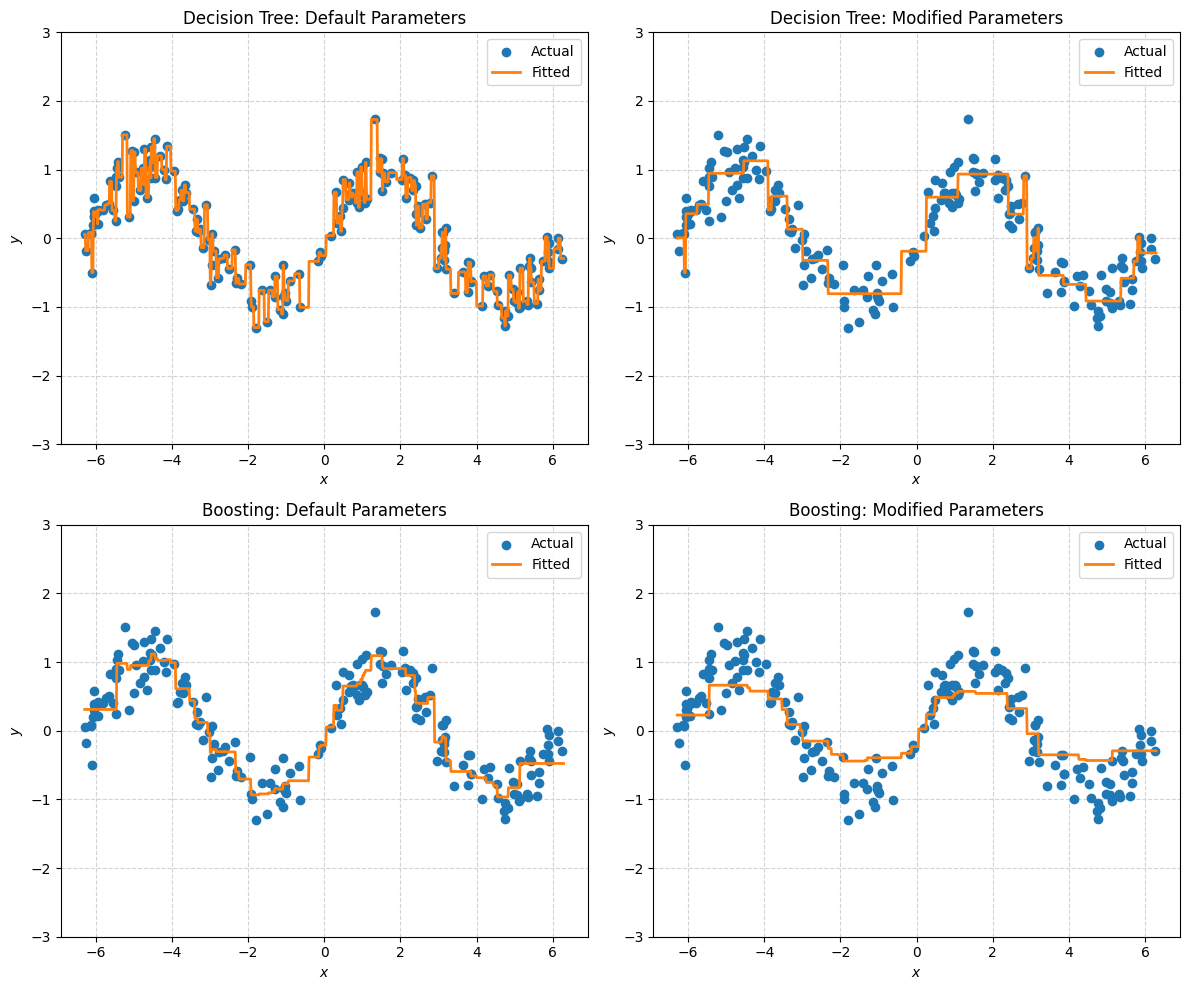

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_sin_regression(
    tree_default,
    X_train,
    y_train,
    "Decision Tree: Default Parameters",
    ax=axs[0, 0],
)
plot_sin_regression(
    tree_modified,
    X_train,
    y_train,
    "Decision Tree: Modified Parameters",
    ax=axs[0, 1],
)
plot_sin_regression(
    hb_default,
    X_train,
    y_train,
    "Boosting: Default Parameters",
    ax=axs[1, 0],
)
plot_sin_regression(
    hb_modified,
    X_train,
    y_train,
    "Boosting: Modified Parameters",
    ax=axs[1, 1],
)

plt.tight_layout()
plt.show()

Here we see similar results as we did with the random forest. The default boosted model works quite well! The non-default boosted model uses a lower learning rate, and from this plot alone, we can clearly see that it "learned" less.

In [76]:
rsme_tree_default = root_mean_squared_error(
    y_test,
    tree_default.predict(X_test),
)

rsme_tree_modified = root_mean_squared_error(
    y_test,
    tree_modified.predict(X_test),
)

rsme_hb_default = root_mean_squared_error(
    y_test,
    hb_default.predict(X_test),
)

rsme_hb_modified = root_mean_squared_error(
    y_test,
    hb_modified.predict(X_test),
)

In [77]:
print(f"Test RMSE for default Tree: {rsme_tree_default:.2f}")
print(f"Test RMSE for modified Tree: {rsme_tree_modified:.2f}")
print(f"Test RMSE for default Boosting: {rsme_hb_default:.2f}")
print(f"Test RMSE for modified Boosting: {rsme_hb_modified:.2f}")

Test RMSE for default Tree: 0.39
Test RMSE for modified Tree: 0.33
Test RMSE for default Boosting: 0.31
Test RMSE for modified Boosting: 0.42


Again, the test metrics match our intuition, with the default boosted model working quite well!

#### Simulated Multiple Feature Data

In [78]:
# simulate some data for regression
X, y = make_regression(
    n_samples=300,
    n_features=5,
    noise=0.3,
    random_state=42,
)

# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
)

In [79]:
dt2 = DecisionTreeRegressor(max_depth=2)
dt5 = DecisionTreeRegressor(max_depth=5)
hb = HistGradientBoostingRegressor()

In [80]:
_ = dt2.fit(X_train, y_train)
_ = dt5.fit(X_train, y_train)
_ = hb.fit(X_train, y_train)

In [81]:
dt2_pred = dt2.predict(X_test)
dt5_pred = dt5.predict(X_test)
hb_pred = hb.predict(X_test)

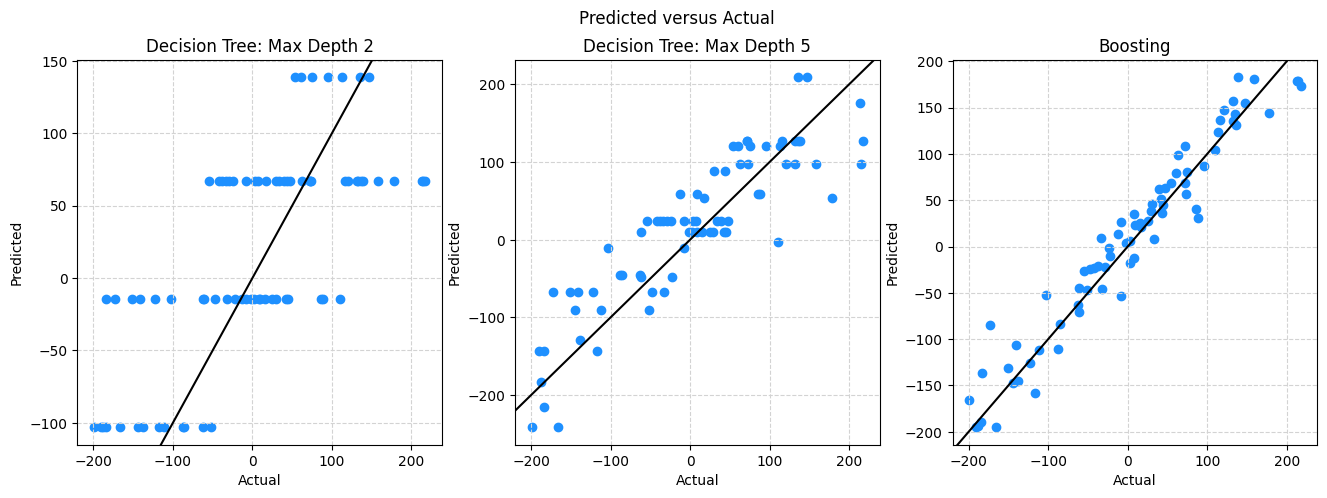

In [82]:
# setup figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 5)
fig.set_dpi(100)

# add overall title
fig.suptitle("Predicted versus Actual")

# create subplot for dt
ax1.set_title("Decision Tree: Max Depth 2")
ax1.scatter(y_test, dt2_pred, color="dodgerblue")
ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.grid(True, linestyle="--", color="lightgrey")
ax1.axline((0, 0), slope=1, color="black")

# create subplot for dt
ax2.set_title("Decision Tree: Max Depth 5")
ax2.scatter(y_test, dt5_pred, color="dodgerblue")
ax2.set_xlabel("Actual")
ax2.set_ylabel("Predicted")
ax2.grid(True, linestyle="--", color="lightgrey")
ax2.axline((0, 0), slope=1, color="black")

# create subplot for rf
ax3.set_title("Boosting")
ax3.scatter(y_test, hb_pred, color="dodgerblue")
ax3.set_xlabel("Actual")
ax3.set_ylabel("Predicted")
ax3.grid(True, linestyle="--", color="lightgrey")
ax3.axline((0, 0), slope=1, color="black")

# shot plot
plt.show()

Much like we saw with random forests, the histogram gradient boosting trees clearly outperform the individual trees. (Again, you should calculate the test RMSE for each to verify!)

### Histogram Gradient Boosting Classification Trees

In [83]:
# simulate some data for classification
X, y = make_blobs(
    n_samples=400,
    cluster_std=3,
    random_state=42,
)

# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.50,
    random_state=42,
)

In [84]:
# create and fit a single decision tree
tree = DecisionTreeClassifier()
_ = tree.fit(X_train, y_train)

# create and fit a boosted model
hb = HistGradientBoostingClassifier()
_ = hb.fit(X_train, y_train)

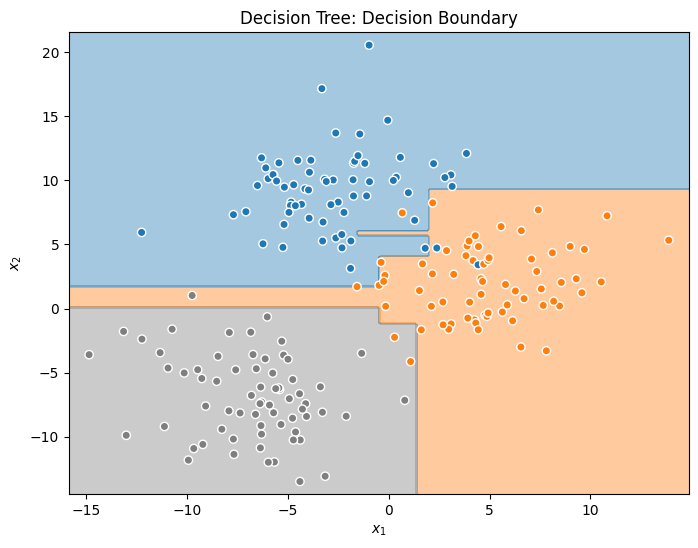

In [85]:
plot_decision_boundary(tree, X_test, y_test, "Decision Tree")

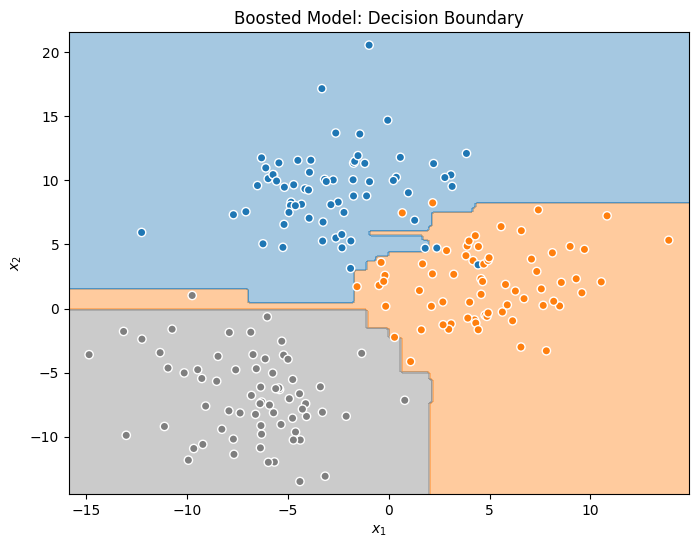

In [86]:
plot_decision_boundary(hb, X_test, y_test, "Boosted Model")

In [87]:
# calculate test accuracies
acc_tree = accuracy_score(y_test, tree.predict(X_test))
acc_hb = accuracy_score(y_test, hb.predict(X_test))

In [88]:
print(f"Test Accuracy for Decision Tree: {acc_tree:.2f}")
print(f"Test Accuracy for Boosted Trees: {acc_rf:.2f}")

Test Accuracy for Decision Tree: 0.97
Test Accuracy for Boosted Trees: 0.95


Again, in this (simple) case, the tree actually outperforms the ensemble!

In [89]:
tree.predict_proba(X_test[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [90]:
np.round(hb.predict_proba(X_test[:10]), 4)

array([[0.    , 1.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    ],
       [1.    , 0.    , 0.    ],
       [0.    , 1.    , 0.    ],
       [0.0052, 0.9948, 0.    ],
       [1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 1.    , 0.    ]])

As always, we can obtain predicted probabilities. The predicted probabilities for the boosted tree seem slightly more reasonable than the tree, but not quite as nice as the random forest we saw previously.

### Tuning

To demonstrate tuning with HGBT, we will use the breast cancer data from `sklearn`.

- [Breast Cancer Wisconsin | `sklearn` Datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

In [91]:
# load cancer data from sklearn
cancer = load_breast_cancer(as_frame=True).frame

# train-test split the data
cancer_train, cancer_test = train_test_split(
    cancer,
    test_size=0.2,
    random_state=42,
)

# create the X and y version of the train data
X_train = cancer_train.iloc[:, :10]
y_train = cancer_train["target"]

# create the X and y version of the test data
X_test = cancer_test.iloc[:, :10]
y_test = cancer_test["target"]

# check shapes of data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((455, 10), (455,), (114, 10), (114,))

For simplicity, we consider only the first 10 features.

In [92]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960


In [93]:
y_train

68     1
181    0
63     1
248    1
60     1
      ..
71     1
106    1
270    1
435    0
102    1
Name: target, Length: 455, dtype: int64

In [94]:
# create pipeline
pipeline = Pipeline(
    steps=[
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42),
        ),
    ]
)

Here we create a pipeline, mostly for consistency. We do not perform any preprocessing, but a `ColumnTransformer` could be added there were a need to add preprocessing like handling of missing data.

In [95]:
HistGradientBoostingClassifier().get_params()

{'categorical_features': 'warn',
 'class_weight': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_features': 1.0,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [96]:
# define parameter grid
param_grid = {
    "classifier__learning_rate": [0.1, 0.25],
    "classifier__max_iter": [100, 200],
    "classifier__max_features": [0.25, 0.5, 1.0],
}

Here we consider a somewhat simple grid, using only a small subset of possible tuning parameters. In general, `learning_rate` and `max_iter` will be the most useful parameters to tune. The learning rate should be greater than `0` and at most `1`. Thing of the learning rate as controlling how much each base learner can learn. The `max_iter` parameter controls the number of learners to use. This parameter needs special attention, as setting it too high can cause overfitting.

Be careful: Specifying a large grid will lead to long tuning times!

In [97]:
# setup grid search with cross-validation
tuned_model = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    verbose=1,
)

In [98]:
# perform grid search with cross-validation
with parallel_backend("loky"):
    tuned_model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [99]:
tuned_model.best_estimator_

Pipeline(steps=[('classifier',
                 HistGradientBoostingClassifier(max_features=0.5, max_iter=200,
                                                random_state=42))])

In [100]:
tuned_model.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_features': 0.5,
 'classifier__max_iter': 200}

In [101]:
cv_results_to_df(tuned_model.cv_results_).style.hide(axis="index")

learning_rate,max_features,max_iter,mean_test_score,std_test_score
0.100000,0.250000,100,0.95,0.02
0.100000,0.250000,200,0.94,0.02
0.100000,0.500000,100,0.95,0.02
0.100000,0.500000,200,0.95,0.01
0.100000,1.000000,100,0.95,0.02
0.100000,1.000000,200,0.95,0.02
0.250000,0.250000,100,0.95,0.02
0.250000,0.250000,200,0.95,0.02
0.250000,0.500000,100,0.95,0.02
0.250000,0.500000,200,0.94,0.01


Here, we actually see very little effect of tuning, but that is due to the simplicity of the data. In practice, tuning will have a greater effect.

In [102]:
print(f"Best Model, CV Accuracy: {tuned_model.best_score_:.2f}")

Best Model, CV Accuracy: 0.95


In [103]:
print(f"Test Accuracy: {tuned_model.score(X_test, y_test):.2f}")

Test Accuracy: 0.96


In [104]:
np.round(tuned_model.predict_proba(X_test[:10]), 3)

array([[0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.481, 0.519],
       [0.247, 0.753],
       [0.   , 1.   ]])

#### Alternatives to Grid Search and Cross-Validation

With big data, and a decent sized grid, performing cross-validation together with a grid search can become computationally expensive.

As an alternative, histogram gradient boosting trees in `sklearn` have parameters for early stopping (`early_stopping`) and validation sets (`validation_fraction`). Consider using these in practice. In CS 307, we will prefer a cross-validated grid search for consistency.

## Summary and Comparison

- **Random Forests** are an *ensemble* of *weak learners* in *parallel*.
    - Random forests do not require much tuning, as they are hard to overfit.
- **Boosted Models** are an *ensemble* of *strong learners* in *sequence*.
    - Boosting is sensitive to tuning, and can overfit.

## Miscellaneous

A related method called [stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html) is another form of an ensemble method that includes a meta-learner on top of the base learners.